In [1]:
import matplotlib.pyplot as plt
import rtlsdr
import numpy as np
import time

In [2]:
# Setup
f_min = 64e6
f_max = 1700e6
rate_best = 2.4e6
df = rate_best

In [3]:
# Open device
sdr = rtlsdr.RtlSdr()
# I feel like this is worrisome:
# [R82XX] PLL not locked!

In [4]:
# Configure device
sdr.sample_rate = rate_best
sdr.gain = 4

In [21]:
# Set up the scan
freqs = np.arange(f_min + df/2.,f_max,df)
nfreq = freqs.shape[0]
npsd_res = 1024 # frequency resolution (number of samples in psd)
npsd_avg = 256 # number of PSDs to average
nsamp = npsd_res*npsd_avg
nfreq_spec = nfreq*npsd_res

samples = np.zeros([nsamp,nfreq],dtype='complex128')

f_all = np.zeros(nfreq_spec)
psd_all = np.zeros(nfreq_spec)
flags_all = np.zeros(nfreq_spec)
indx = np.arange(npsd_res)

In [22]:
print('Length of scan',nsamp/df,'seconds')
t_set = 0.06
print('Estimated time to scan',(nsamp/df+t_set)*nfreq,'seconds')

Length of scan 0.10922666666666667 seconds
Estimated time to scan 115.41258666666667 seconds


In [23]:
samples.shape

(262144, 682)

In [24]:
t_acq1 = time.time()
for i,freq in enumerate(freqs):
    #print(freq)
    #t1 = time.time()
    sdr.center_freq = freq
    #t2 = time.time()
    #print('Set',t2-t1)
    #t1 = time.time()
    samples[:,i] = sdr.read_samples(nsamp)
    #t2 = time.time()
    #print('Acq',t2-t1)
t_acq2 = time.time()
print('Actual time to scan',t_acq2-t_acq1)

Actual time to scan 122.64890599250793


In [25]:
psd_array = np.zeros([npsd_res,nfreq])
freq_array = np.zeros([npsd_res,nfreq])

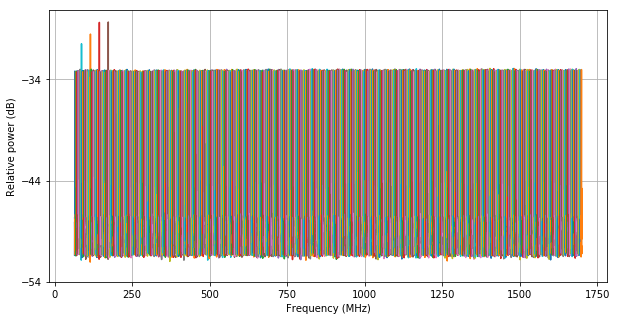

In [26]:
plt.figure(1,figsize=(10,5))
plt.clf()

for i,freq in enumerate(freqs):
    fc_mhz = freq/1e6
    bw_mhz = sdr.sample_rate/1e6
    # use matplotlib to estimate and plot the PSD
    psd_array[:,i],freq_array[:,i] = plt.psd(samples[:,i], NFFT=npsd_res, Fs=bw_mhz, Fc=fc_mhz)
    
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative power (dB)')
plt.show()

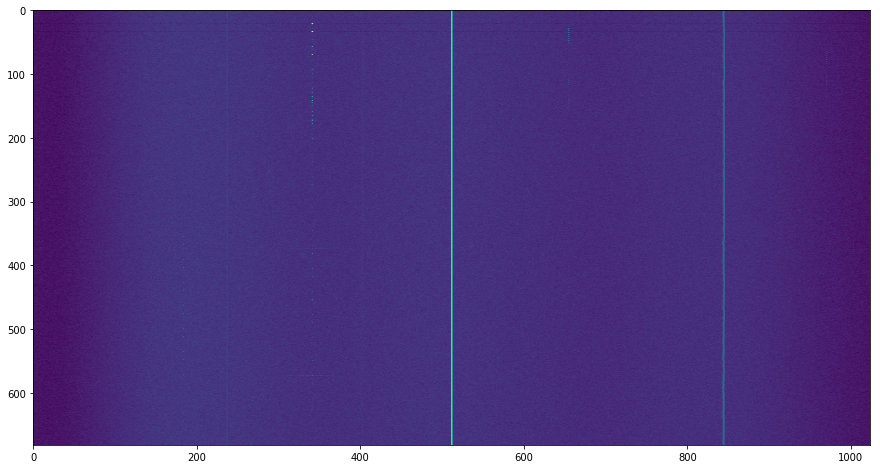

In [27]:
plt.figure(figsize=(15,8))
plt.imshow(np.log10(psd_array).T,aspect='auto')
plt.show()

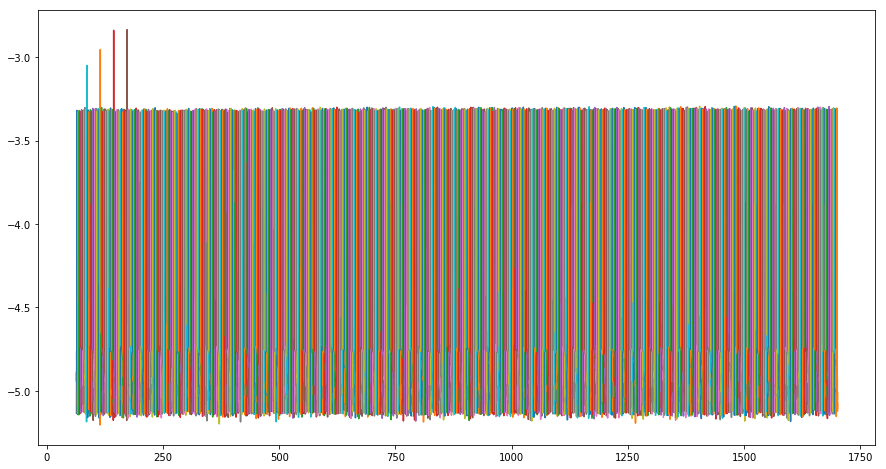

In [28]:
plt.figure(figsize=(15,8))
plt.plot(freq_array,np.log10(psd_array))
plt.show()

In [29]:
bckgrnd = np.median(psd_array,axis=1)
bckgrnd_array = np.outer(bckgrnd,np.ones(nfreq))
bckgrnd_array.shape

(1024, 682)

In [30]:
flags = np.ones(npsd_res)
ctr = int(npsd_res/2.)
flags[ctr-2:ctr+2] = 0.
off = int(0.826*npsd_res)
flags[off-3:off+2] = 0.
flags_array = np.outer(flags,np.ones(nfreq))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


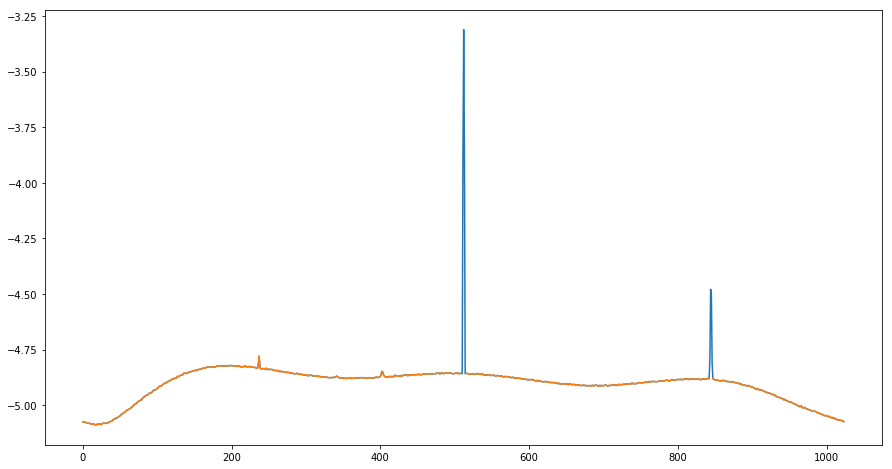

In [31]:
plt.figure(figsize=(15,8))
plt.plot(np.log10(bckgrnd))
plt.plot(np.log10(bckgrnd/flags))
plt.show()

In [32]:
psd_all = np.reshape((psd_array/bckgrnd_array).T,nfreq_spec)
freq_all = np.reshape(freq_array.T,nfreq_spec)
flags_all = np.reshape(flags_array.T,nfreq_spec)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


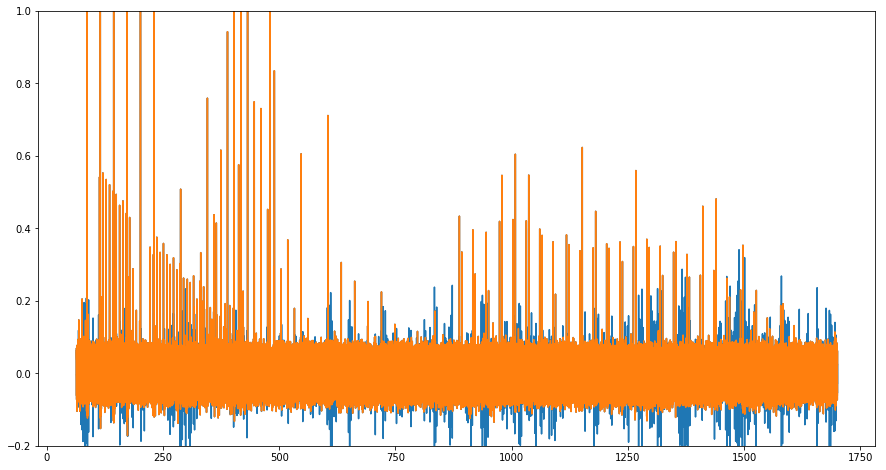

In [34]:
plt.figure(figsize=(15,8))
plt.plot(freq_all,np.log10(psd_all))
plt.plot(freq_all,np.log10(psd_all/flags_all))
#plt.xlim([1250,1500])
plt.ylim([-0.2,1])
plt.show()

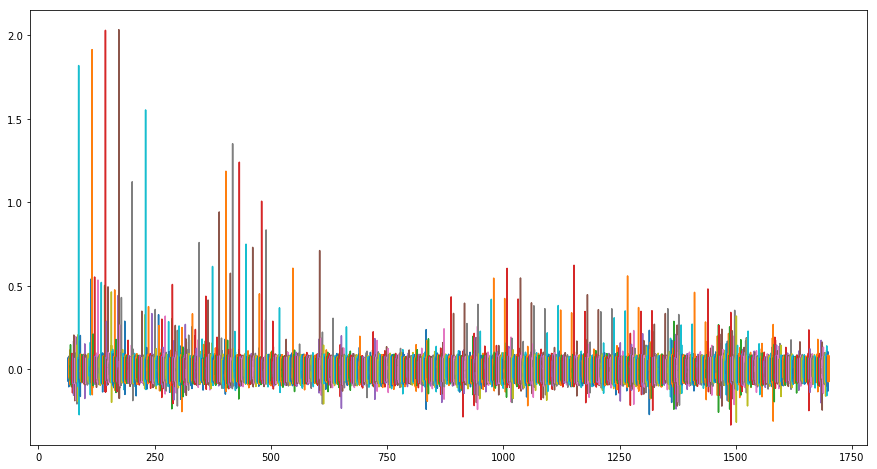

In [35]:
plt.figure(figsize=(15,8))
plt.plot(freq_array,np.log10(psd_array/bckgrnd_array))#/flags_array))
#plt.xlim([740,760])
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


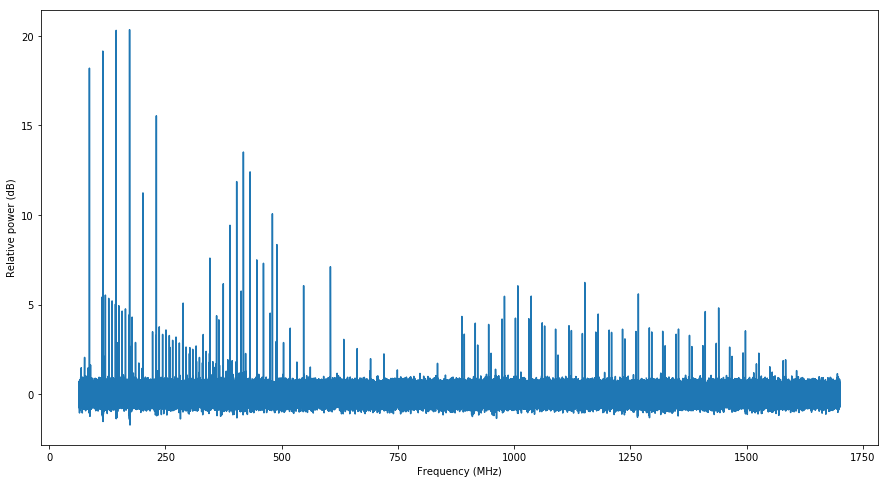

In [36]:
#%%
plt.figure(figsize=(15,8))
plt.clf()
plt.plot(freq_all,10.*np.log10(psd_all/flags_all))

plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative power (dB)')
tm = time.ctime().replace(' ','_')
plt.savefig('SDRFrequencyScan_'+tm+'.png')


plt.show()

In [87]:
np.savez('SDRFrequencyScan_'+tm+'.npz',
         f_all=f_all,
         psd_all=psd_all,
         flags_all=flags_all,
         f_min=f_min,
         f_max=f_max,
         rate_best=rate_best,
         df=df,
         samples=samples,
         psd_array=psd_array,
         freq_array=freq_array,
         flags_array=flags_array,
         bckgrnd_array=bckgrnd_array
        )

In [37]:
sdr.close()


In [38]:
from astropy import units as u

In [40]:
7*u.arcsec/((30*u.deg/u.s).to(u.arcsec/u.s))

<Quantity 6.48148148e-05 s>